In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
from scipy.special import gamma
import jax.numpy as jnp
import jax

# aCSS Sampling Demo

As an extremely simple toy demo, draw a vector of samples:

$$
\vec X \sim N(0,1)
$$

Our goal will be to construct and sample from an aCSS likelihood, producing new observations $\tilde X$ with (approximately) the same sample means as $\vec X$

## Step 1: Draw some data

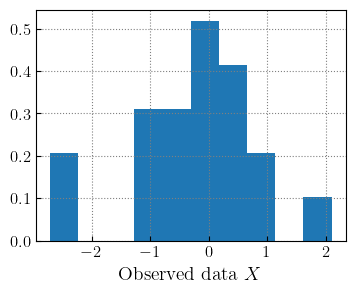

In [2]:
xs = np.random.normal(0,1,size=20)

fig,ax = plt.subplots(figsize=(4,3))
ax.hist(xs,bins=10,density=True)
ax.set_xlabel('Observed data $X$')
plt.show()

In [3]:
# Estimate summary statistic
mu_hat = np.mean(xs)
mu_hat

-0.24102478838058294

## Step 2: Build the aCSS likelihood

The likelihood for data $\vec x$ is
    $$
    p(x|\mu) = \frac{1}{\sqrt{2\pi}} \mathrm{exp}\left[-\frac{|\vec x-\mu|^2}{2}\right]
    $$
with corresponding loss function
    $$
    \mathcal{L}(\mu;x) = - \ln p(x|\mu)
    $$

The full likelihood conditioned on (approximate) sample means $\hat \mu$ is

$$
p_{\hat \mu}(x| \hat \mu) \propto p(x|\hat \mu)\cdot
    \mathrm{exp}\left[-\frac{|\nabla_\mu\mathcal{L}(\hat \mu;x)|^2}{2\epsilon^2}\right] \cdot
    \mathrm{Det}\left(\nabla^2_\mu\mathcal{L}(\hat \mu;x)\right)
$$

In [4]:
# Log-likelihood for our observed data
def log_likelihood(mu,xs):
    mean_vector = jnp.full(xs.shape,mu)
    return -jnp.sum((mean_vector-xs)**2)/2.

# Trivially convert to a loss function
# This is where we would put additional regularization/penalties
def loss(mu,xs):
    return -log_likelihood(mu,xs)

# The conditional aCSS likelihood depends on gradients of the loss function
# Compute these numerically with jax magic
grad_loss = jax.grad(loss,0)
grad2_loss = jax.grad(grad_loss,0)

# Put the pieces together
def conditioned_log_likelihood(mu,xs,eps2):
    return log_likelihood(mu,xs) - jnp.square(grad_loss(mu,xs))/(2.*eps2) + jnp.log(grad2_loss(mu,xs))

# JIT compile
jitted_conditioned_log_likelihood = jax.jit(conditioned_log_likelihood)

## Step 3: Sample over the aCSS likelihood

I'll do this via vanilla Metropolis-Hastings sampling

In [5]:
# Declare the size of perturbation to apply to loss function
eps = 1e-1

# Initialize chain
nSteps = 10000
chain = np.zeros((nSteps,xs.size))

# Start sampler at the observed data
xCurrent = xs

# Loop!
for i in range(nSteps):
    
    # Propose new point
    xProposed = xCurrent+np.random.normal(0,1e-1,size=xs.size)
    
    # Compute log-likelihood difference
    log_likelihood_ratio = jitted_conditioned_log_likelihood(mu_hat,xProposed,eps**2)\
                                - jitted_conditioned_log_likelihood(mu_hat,xCurrent,eps**2)
    
    # Reject/accept
    likelihood_ratio = np.exp(log_likelihood_ratio)
    if np.random.random()<likelihood_ratio:
        xCurrent = xProposed
        
    # Store!    
    chain[i,:] = xCurrent

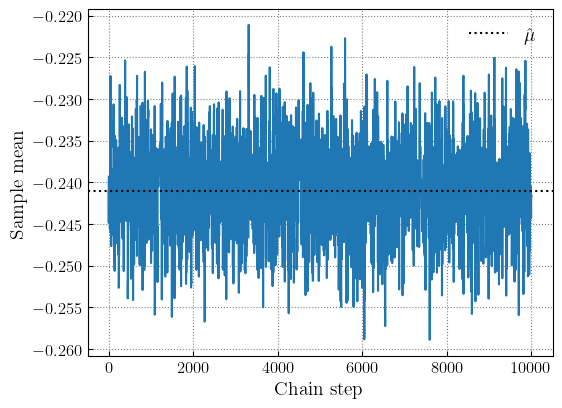

In [19]:
# Verify that this worked as intended by plotting the sample means at each step in our chain
means = np.mean(chain,axis=1)

fig,ax = plt.subplots()
ax.plot(means)
ax.axhline(y=mu_hat,color='black',ls=':',label="$\hat \mu$")
ax.set_xlabel('Chain step')
ax.set_ylabel('Sample mean')
ax.legend(loc='upper right')
plt.show()